In [1]:
### 4.3 Classification Model

In [2]:
import tensorflow as tf
from d2l import tensorflow as d2l

2024-02-12 21:32:22.504452: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-12 21:32:22.504483: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-12 21:32:22.505340: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-12 21:32:22.511150: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-12 21:32:23.173010: W tensorflow/compiler/tf2

We define the Classifier class below. In the validation_step we report both the loss value and the classification accuracy on a validation batch. We draw an update for every num_val_batches batches. This has the benefit of generating the averaged loss and accuracy on the whole validation data. These average numbers are not exactly correct if the final batch contains fewer examples, but we ignore this minor difference to keep the code simple.

In [3]:
class Classifier(d2l.Module):  #@save
    """The base class of classification models."""
    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)
        self.plot('acc', self.accuracy(Y_hat, batch[-1]), train=False)

By default we use a stochastic gradient descent optimizer, operating on minibatches, just as we did in the context of linear regression.

### 4.3.2. Accuracy
Given the predicted probability distribution y_hat, we typically choose the class with the highest predicted probability whenever we must output a hard prediction. Indeed, many applications require that we make a choice. For instance, Gmail must categorize an email into “Primary”, “Social”, “Updates”, “Forums”, or “Spam”. It might estimate probabilities internally, but at the end of the day it has to choose one among the classes.

When predictions are consistent with the label class y, they are correct. The classification accuracy is the fraction of all predictions that are correct. Although it can be difficult to optimize accuracy directly (it is not differentiable), it is often the performance measure that we care about the most. It is often the relevant quantity in benchmarks. As such, we will nearly always report it when training classifiers.

Accuracy is computed as follows. First, if y_hat is a matrix, we assume that the second dimension stores prediction scores for each class. We use argmax to obtain the predicted class by the index for the largest entry in each row. Then we compare the predicted class with the ground truth y elementwise. Since the equality operator == is sensitive to data types, we convert y_hat’s data type to match that of y. The result is a tensor containing entries of 0 (false) and 1 (true). Taking the sum yields the number of correct predictions.

In [4]:
@d2l.add_to_class(Classifier)  #@save
def accuracy(self, Y_hat, Y, averaged=True):
    """Compute the number of correct predictions."""
    Y_hat = tf.reshape(Y_hat, (-1, Y_hat.shape[-1]))
    preds = tf.cast(tf.argmax(Y_hat, axis=1), Y.dtype)
    compare = tf.cast(preds == tf.reshape(Y, -1), tf.float32)
    return tf.reduce_mean(compare) if averaged else compare

### 4.4.1. The Softmax
Let’s begin with the most important part: the mapping from scalars to probabilities. For a refresher, recall the operation of the sum operator along specific dimensions in a tensor, as discussed in Section 2.3.6 and Section 2.3.7. Given a matrix X we can sum over all elements (by default) or only over elements in the same axis. The axis variable lets us compute row and column sums:

In [5]:
X = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
tf.reduce_sum(X, 0, keepdims=True), tf.reduce_sum(X, 1, keepdims=True)

(<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[5., 7., 9.]], dtype=float32)>,
 <tf.Tensor: shape=(2, 1), dtype=float32, numpy=
 array([[ 6.],
        [15.]], dtype=float32)>)

Computing the softmax requires three steps: (i) exponentiation of each term; (ii) a sum over each row to compute the normalization constant for each example; (iii) division of each row by its normalization constant, ensuring that the result sums to 1:
    $\text{softmax}(X_{ij}) = \frac{e^{X_{ij}}}{\sum_{k} e^{X_{ik}}}$

In [6]:
def softmax(X):
    X_exp = tf.exp(X)
    partition = tf.reduce_sum(X_exp, 1, keepdims=True)
    return X_exp / partition  # The broadcasting mechanism is applied here

In [7]:
x = tf.constant([[1, 2, 3], [4, 5, 6],[90000,200,10]])

# Sum along axis 1 without keeping dimensions
result_without_keepdims = tf.reduce_sum(x, axis=1)

# Sum along axis 1 and keep reduced dimensions
result_with_keepdims = tf.reduce_sum(x, axis=1, keepdims=True)

print("Without keepdims:")
print(result_without_keepdims.numpy())

print("With keepdims:")
print(result_with_keepdims.numpy())

Without keepdims:
[    6    15 90210]
With keepdims:
[[    6]
 [   15]
 [90210]]


For any input X, we turn each element into a nonnegative number. **Each row sums up to 1**, as is required for a probability. Caution: the code above is not robust against very large or very small arguments. While it is sufficient to illustrate what is happening, you should not use this code verbatim for any serious purpose. Deep learning frameworks have such protections built in and we will be using the built-in softmax going forward.

In [8]:
X = tf.random.uniform((2, 5))
X_prob = softmax(X)  
X_prob, tf.reduce_sum(X_prob, 1).numpy()

(<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
 array([[0.19805269, 0.2536937 , 0.2555402 , 0.11807537, 0.17463805],
        [0.23989528, 0.18475734, 0.19616684, 0.1723379 , 0.20684265]],
       dtype=float32)>,
 array([1., 1.], dtype=float32))

So,the sum of all values of Softmax(X) = 1... which is expected...check!!

#### 4.4.2. The Model
We now have everything that we need to implement the softmax regression model. As in our linear regression example, each instance will be represented by a fixed-length vector. Since the raw data here consists of 28 x28 pixel images, we flatten each image, treating them as vectors of length 784. In later chapters, we will introduce convolutional neural networks, which exploit the spatial structure in a more satisfying way.

In softmax regression, the number of outputs from our network should be equal to the number of classes. Since our dataset has 10 classes, our network has an output dimension of 10. Consequently, our weights constitute a 784 x 10 matrix plus a 1 x 10 row vector for the biases. As with linear regression, we initialize the weights W with Gaussian noise. The biases are initialized as zeros.

In [9]:
class SoftmaxRegressionScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W = tf.random.normal((num_inputs, num_outputs), 0, sigma)
        self.b = tf.zeros(num_outputs)
        self.W = tf.Variable(self.W)
        self.b = tf.Variable(self.b)

In [10]:
@d2l.add_to_class(SoftmaxRegressionScratch)
def forward(self, X):
    X = tf.reshape(X, (-1, self.W.shape[0]))
    return softmax(tf.matmul(X, self.W) + self.b)

### 4.4.3. The Cross-Entropy Loss
Next we need to implement the cross-entropy loss function (introduced in Section 4.1.2). This may be the most common loss function in all of deep learning. At the moment, applications of deep learning easily cast as classification problems far outnumber those better treated as regression problems.

Recall that cross-entropy takes the negative log-likelihood of the predicted probability assigned to the true label. For efficiency we avoid Python for-loops and use indexing instead. In particular, the one-hot encoding in $y$ allows us to select the matching terms in \y_hat.

To see this in action we create sample data y_hat with 2 examples of predicted probabilities over 3 classes and their corresponding labels y. The correct labels are 0 and 2 respectively (i.e., the first and third class). Using y as the indices of the probabilities in y_hat, we can pick out terms efficiently.

In [11]:
y_hat = tf.constant([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y = tf.constant([0, 2])
tf.boolean_mask(y_hat, tf.one_hot(y, depth=y_hat.shape[-1]))

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.1, 0.5], dtype=float32)>

In [12]:
tf.one_hot(y, depth=y_hat.shape[-1])

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 0., 0.],
       [0., 0., 1.]], dtype=float32)>

Now we can implement the cross-entropy loss function by averaging over the logarithms of the selected probabilities.

In [13]:
def cross_entropy(y_hat, y):
    return -tf.reduce_mean(tf.math.log(tf.boolean_mask(
        y_hat, tf.one_hot(y, depth=y_hat.shape[-1]))))

cross_entropy(y_hat, y)

<tf.Tensor: shape=(), dtype=float32, numpy=1.4978662>

In [14]:
@d2l.add_to_class(SoftmaxRegressionScratch)
def loss(self, y_hat, y):
    return cross_entropy(y_hat, y)

### 4.4.4. Training
We reuse the fit method defined in Section 3.4 to train the model with 10 epochs. Note that the number of epochs (max_epochs), the minibatch size (batch_size), and learning rate (lr) are adjustable hyperparameters. That means that while these values are not learned during our primary training loop, they still influence the performance of our model, both vis-à-vis training and generalization performance. In practice you will want to choose these values based on the validation split of the data and then, ultimately, to evaluate your final model on the test split. As discussed in Section 3.6.3, we will regard the test data of Fashion-MNIST as the validation set, thus reporting validation loss and validation accuracy on this split.

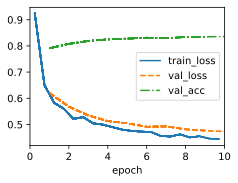

In [15]:
data = d2l.FashionMNIST(batch_size=256)
model = SoftmaxRegressionScratch(num_inputs=784, num_outputs=10, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

Because we synthesized the dataset ourselves, we know precisely what the true parameters are. Thus, we can evaluate our success in training by comparing the true parameters with those that we learned through our training loop. Indeed they turn out to be very close to each other.

In [16]:
print(f'error in estimating w: {data.w - tf.reshape(model.w, data.w.shape)}')
print(f'error in estimating b: {data.b - model.b}')

AttributeError: 'FashionMNIST' object has no attribute 'w'

We should not take the ability to exactly recover the ground truth parameters for granted. In general, for deep models unique solutions for the parameters do not exist, and even for linear models, exactly recovering the parameters is only possible when no feature is linearly dependent on the others. However, in machine learning, we are often less concerned with recovering true underlying parameters, but rather with parameters that lead to highly accurate prediction (Vapnik, 1992). Fortunately, even on difficult optimization problems, stochastic gradient descent can often find remarkably good solutions, owing partly to the fact that, for deep networks, there exist many configurations of the parameters that lead to highly accurate prediction.

#### 3.4.5. Summary
In this section, we took a significant step towards designing deep learning systems by implementing a fully functional neural network model and training loop. In this process, we built a data loader, a model, a loss function, an optimization procedure, and a visualization and monitoring tool. We did this by composing a Python object that contains all relevant components for training a model. While this is not yet a professional-grade implementation it is perfectly functional and code like this could already help you to solve small problems quickly. In the coming sections, we will see how to do this both more concisely (avoiding boilerplate code) and more efficiently (using our GPUs to their full potential).


### 4.5. Concise Implementation of Softmax Regression
 Just as high-level deep learning frameworks made it easier to implement linear regression (see Section 3.5), they are similarly convenient here.

In [17]:
import tensorflow as tf
from d2l import tensorflow as d2l

We use a Flatten layer to convert the fourth-order tensor X by keeping the dimension along the first axis unchanged.

In [18]:
class SoftmaxRegression(d2l.Classifier):  #@save
    """The softmax regression model."""
    def __init__(self, num_outputs, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = tf.keras.models.Sequential()
        self.net.add(tf.keras.layers.Flatten())
        self.net.add(tf.keras.layers.Dense(num_outputs))

    def forward(self, X):
        return self.net(X)

This avoids both overflow and underflow. We will want to keep the conventional softmax function handy in case we ever want to evaluate the output probabilities by our model. But instead of passing softmax probabilities into our new loss function, we just pass the logits and compute the softmax and its log all at once inside the cross-entropy loss function, which does smart things like the “LogSumExp trick”.

In [19]:
@d2l.add_to_class(d2l.Classifier)  #@save
def loss(self, Y_hat, Y, averaged=True):
    Y_hat = tf.reshape(Y_hat, (-1, Y_hat.shape[-1]))
    Y = tf.reshape(Y, (-1,))
    fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    return fn(Y, Y_hat)

#### 4.5.3. Training
Next we train our model. We use Fashion-MNIST images, flattened to 784-dimensional feature vectors.

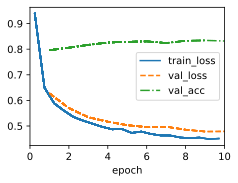

In [20]:
data = d2l.FashionMNIST(batch_size=256)
model = SoftmaxRegression(num_outputs=10, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)